# January 30 - February 2, 2023: Simulating linear dynamics model

In [1]:
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import tvb
import tvb.simulator.lab as tsl
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
from tvb.simulator.plot.timeseries_interactive import TimeSeriesInteractivePlotter

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')
month_dir = f"{proj_dir}/nb/jan23"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils_v1 as dataset_utils
# import helpers.fc_utils as fc_utils
# import helpers.isc_utils as isc_utils
# import helpers.network_utils as network_utils

/home/govindas/.local/lib/python3.9/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
def plot_roi_time_series(args, time, data):
    # plot the time series of all rois.
    # %matplotlib inline
    if args.subplot_layout == 'row-col':
        nrows, ncols = int(np.ceil(args.num_rois / 2)), 2
        figsize = (5*ncols, 4*nrows)
    elif args.subplot_layout == 'row':
        nrows, ncols = args.num_rois, 1
        figsize = (10*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=True, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    state_var = 0

    for idx_roi, roi in enumerate(np.arange(data.shape[2])):
        if args.subplot_layout == 'row-col':
            ax = axs[idx_roi // ncols, idx_roi % ncols]
        elif args.subplot_layout == 'row':
            ax = axs[idx_roi]
        

        ax.set_title(f"ROI {roi:02}")

        ax.plot(
            data[:, state_var, idx_roi, 0],
            color='cornflowerblue',
            linewidth=3,
        )

        # ax.fill_between()

        ax.set_xlabel(f"time (s)")
        ax.set_ylabel(f"activity")

        spc = len(time) // 5
        pos = np.arange(0, len(time), spc)
        labels = np.round(time[::spc]) / 1000
        #f"{np.array2string(time[::spc], precision=2, floatmode='fixed')}".split(" ")
        ax.set_xticks(pos, labels)
        ax.grid(True)

    # fig.show()

    return None

In [3]:
def display_network(args, network):
    nrows, ncols = 1, 2
    figsize = (5*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=True, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    nws = {'weights': network.weights, 'tract_lengths': network.tract_lengths}

    for idx, (name, nw) in enumerate(nws.items()):
        ax = axs[idx]
        im = ax.imshow(nw, cmap=args.cmap)
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(f"{name}")

    return None

In [4]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

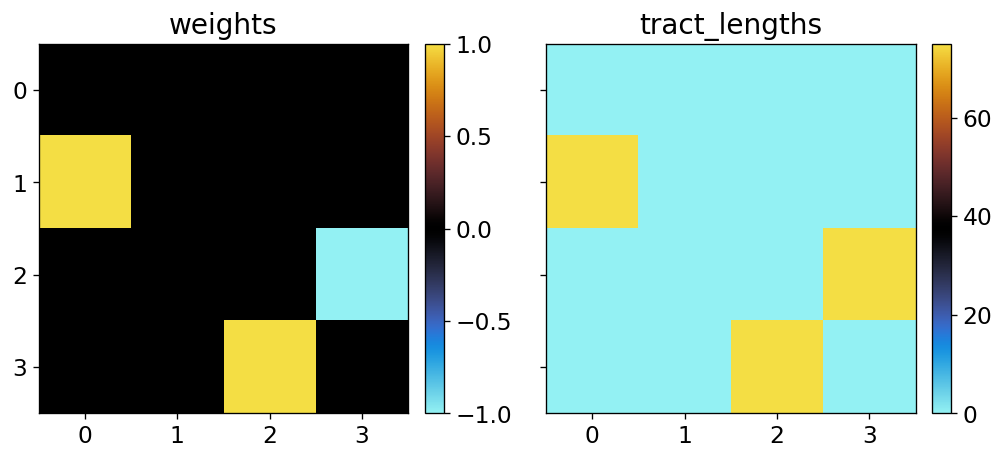

In [5]:
network = tsl.connectivity.Connectivity()

args.num_rois = 4
network.number_of_regions = args.num_rois

# weights – connection strengths, i.e. fiber density
weights = np.zeros(shape=([args.num_rois]*2))
weights[1, 0] = 1.0
weights[2, 3] = -1.0
weights[3, 2] = 1.0
network.set_weights(weights, args.num_rois)

# fibre lengths 
tract_lengths = np.zeros_like(weights)
tract_lengths[1, 0] = 75.0
tract_lengths[3, 2] = 75.0
tract_lengths[2, 3] = 75.0
network.set_tract_lengths(tract_lengths, args.num_rois)

# roi centers
network.centres_spherical(args.num_rois)

# roi names
network.create_region_labels()

# hemispheres
hemispheres = np.array(
    [False for _ in range(len(network.region_labels) // 2)] + # left
    [True for _ in range(len(network.region_labels) // 2)]    # right
)
network.set_hemispheres(hemispheres, args.num_rois)

# configure
network.configure()

# display network
args.cmap = cmr.iceburn
display_network(args, network)

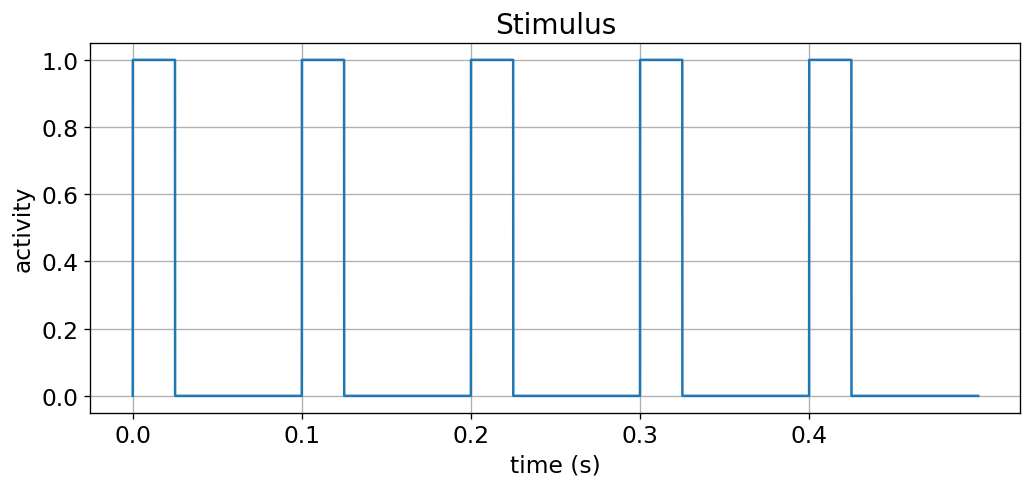

In [6]:
args.roi_weights = np.zeros(args.num_rois)
args.roi_weights[0] = 1.0
args.roi_weights[2] = 1.0

eq = tvb.datatypes.equations.PulseTrain()
eq.parameters['onset'] = 0.0 # ms 
eq.parameters['T'] = 100.0 # ms
eq.parameters['tau'] = 25.0 # ms
eq.parameters['amp'] = 1.0 # A.U.

stimulus = tsl.patterns.StimuliRegion(
    temporal=eq,
    connectivity=network,
    weight=args.roi_weights,
)

stimulus.configure()

time = np.arange(0.0, 5e2, 0.01)
y = stimulus.temporal.evaluate(time)
fig, axs = plt.subplots(
    nrows=1, 
    ncols=1,
    figsize=(10, 4),
    sharex=True, 
    sharey=True, 
    dpi=120,
)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.5
)

ax = axs
ax.set_title(f"Stimulus")
ax.plot(y)
ax.set_xlabel(f"time (s)")
ax.set_ylabel(f"activity")

spc = len(time) // 5
pos = np.arange(0, len(time), spc)
labels = np.round(time[::spc]) / 1000
#f"{np.array2string(time[::spc], precision=2, floatmode='fixed')}".split(" ")
ax.set_xticks(pos, labels)
ax.grid(True)

WARNING  random_state supplied for non-stochastic integration
   INFO  step 1 time 0.0000 s


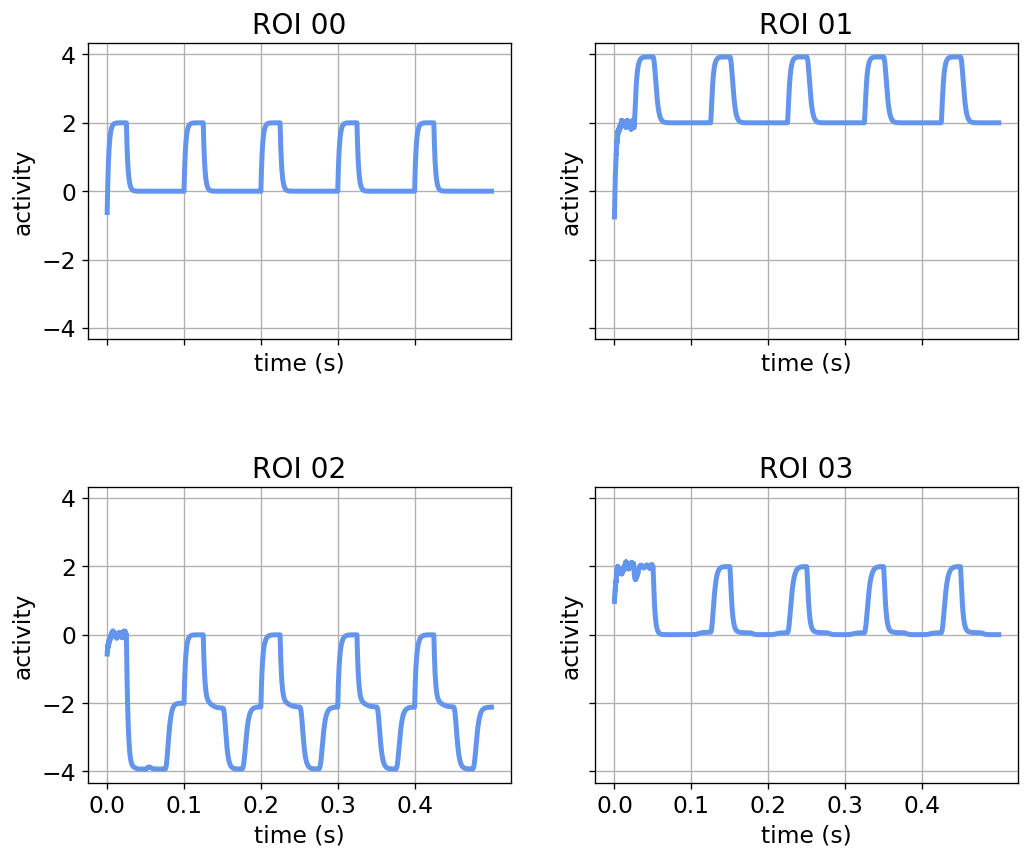

In [7]:
model = tsl.models.Linear(
    gamma=np.array([-0.5]),
)

coupling = tsl.coupling.HyperbolicTangent()

integrator = tsl.integrators.HeunDeterministic(dt=2**-6)

monitors = (
    tsl.monitors.RawVoi(),
    tsl.monitors.ProgressLogger(period=1e3),
)

sim = tsl.simulator.Simulator(
    model=model, 
    connectivity=network, 
    coupling=coupling, 
    integrator=integrator,
    monitors=monitors,
    stimulus=stimulus,
    simulation_length=5e2,
).configure()

sim.initial_conditions = np.random.rand(*sim.good_history_shape)

run_res = sim.run()
time, data = run_res[0]
# `data` dimensions are ("Time", "State Variable", "Region", "Mode")
time.shape, data.shape

args.subplot_layout = 'row-col'
plot_roi_time_series(args, time, data)